In [14]:
# importovanje biblioteka koje ce nam biti potrebne kasnije
import numpy as np
import pandas as pd 
import time
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn import model_selection
import os
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import pandas.core.algorithms as algos
from pandas import Series
import scipy.stats.stats as stats
import re
import traceback
import string

In [2]:
#Ucitavanje fajla sa podacima za trening
data = pd.read_csv('C:\\Users\\Vlada\\Desktop\\Milica master\\all_variables.csv')
X = data.drop('TARGET', axis = 1)
y = data['TARGET']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)
print('Dimenzije trening skupa: ', X_train.shape)
X_train.head()

Dimenzije trening skupa:  (246008, 1543)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,client_installments_AMT_PAYMENT_min_count,client_installments_AMT_PAYMENT_min_mean,client_installments_AMT_PAYMENT_min_max,client_installments_AMT_PAYMENT_min_min,client_installments_AMT_PAYMENT_min_sum,client_installments_AMT_PAYMENT_sum_count,client_installments_AMT_PAYMENT_sum_mean,client_installments_AMT_PAYMENT_sum_max,client_installments_AMT_PAYMENT_sum_min,client_installments_AMT_PAYMENT_sum_sum
181648,310536,Cash loans,F,N,N,2,90000.0,227520.0,13189.5,180000.0,...,57.0,3846.4800,10338.120,75.555,219249.360,57.0,160426.550,223200.000,32691.105,9144313.00
229245,365516,Cash loans,M,Y,Y,0,90000.0,161730.0,13095.0,135000.0,...,27.0,9602.7900,13984.650,3826.665,259275.330,27.0,84089.430,153913.500,22835.790,2270414.80
122525,242055,Cash loans,M,N,Y,0,135000.0,728847.0,26307.0,553500.0,...,4.0,12985.4700,12985.470,12985.470,51941.880,4.0,51958.484,51958.484,51958.484,207833.94
306311,454894,Cash loans,M,N,N,0,135000.0,474183.0,34636.5,391500.0,...,82.0,7269.0425,13692.825,4764.825,596061.500,82.0,759773.440,1170179.200,28595.521,62301424.00
300658,448321,Cash loans,F,N,Y,0,180000.0,254700.0,27558.0,225000.0,...,11.0,3102.6150,3102.615,3102.615,34128.766,11.0,37066.230,37066.230,37066.230,407728.53


In [4]:
max_bin = 20
force_bin = 3

#funkcija koja deli na optimalne grupe
def mono_bin(Y, X, n = max_bin):
    
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]
    r = 0
    while np.abs(r) < 1:
        try:
            d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.qcut(notmiss.X, n)})
            d2 = d1.groupby('Bucket', as_index=True)
            r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)
            n = n - 1 
        except Exception as e:
            n = n - 1
            
    
    if len(d2) == 1:
        n = force_bin         
        bins = algos.quantile(notmiss.X, np.linspace(0, 1, n))
        if len(np.unique(bins)) == 2:
            bins = np.insert(bins, 0, 1)
            bins[1] = bins[1]-(bins[1]/2)
        d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.cut(notmiss.X, np.unique(bins),include_lowest=True)}) 
        d2 = d1.groupby('Bucket', as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["MIN_VALUE"] = d2.min().X
    d3["MAX_VALUE"] = d2.max().X
    d3["COUNT"] = d2.count().Y
    d3["EVENT"] = d2.sum().Y
    d3["NONEVENT"] = d2.count().Y - d2.sum().Y
    d3=d3.reset_index(drop=True)
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]       
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    
    return(d3)
    

def data_vars(df1, target):
    
    stack = traceback.extract_stack()
    filename, lineno, function_name, code = stack[-2]
    vars_name = re.compile(r'\((.*?)\).*$').search(code).groups()[0]
    final = (re.findall(r"[\w']+", vars_name))[-1]
    
    x = df1.dtypes.index
    count = -1
    
    for i in x:
        if i.upper() not in (final.upper()):
            conv = mono_bin(target, df1[i])
            conv["VAR_NAME"] = i
            count = count + 1
                
            if count == 0:
                iv_df = conv
            else:
                iv_df = iv_df.append(conv,ignore_index=True)
    
    iv = pd.DataFrame({'IV':iv_df.groupby('VAR_NAME').IV.max()})
    iv = iv.reset_index()
    return(iv_df,iv)

final_iv, IV = data_vars(X_train,y_train)

In [ ]:
final_iv.to_csv("final_iv.csv",index = False, chunksize = 500)

In [6]:
final_iv=pd.read_csv("C:\\Users\\Vlada\\Desktop\\Milica master\\final_iv.csv")

In [7]:
final_iv[final_iv['VAR_NAME']=='EXT_SOURCE_3']

,VAR_NAME,MIN_VALUE,MAX_VALUE,COUNT,EVENT,EVENT_RATE,NONEVENT,NON_EVENT_RATE,DIST_EVENT,DIST_NON_EVENT,WOE,IV
259,EXT_SOURCE_3,0.0005272652387098817,0.18195910978627847,13182,2848.0,0.216052,10334.0,0.783948,0.143404,0.045696,1.143660,0.334593
260,EXT_SOURCE_3,0.18303516721781032,0.266456808245056,13309,2044.0,0.153580,11265.0,0.846420,0.102920,0.049813,0.725690,0.334593
261,EXT_SOURCE_3,0.2678689358444539,0.3296550543128238,12989,1559.0,0.120025,11430.0,0.879975,0.078499,0.050542,0.440285,0.334593
262,EXT_SOURCE_3,0.33125086459090186,0.3842068130556564,13416,1319.0,0.098315,12097.0,0.901685,0.066415,0.053492,0.216398,0.334593
263,EXT_SOURCE_3,0.3859146722745145,0.4311917977993083,12923,1186.0,0.091774,11737.0,0.908226,0.059718,0.051900,0.140322,0.334593
264,EXT_SOURCE_3,0.4329616670974407,0.475849908720221,13504,1027.0,0.076052,12477.0,0.923948,0.051712,0.055172,-0.064763,0.334593
265,EXT_SOURCE_3,0.4776491548517548,0.5154953751603267,12906,840.0,0.065086,12066.0,0.934914,0.042296,0.053354,-0.232263,0.334593
266,EXT_SOURCE_3,0.5172965813614878,0.5531646987710016,13028,757.0,0.058106,12271.0,0.941894,0.038117,0.054261,-0.353149,0.334593
267,EXT_SOURCE_3,0.5549467685334323,0.5902333386185574,13085,651.0,0.049752,12434.0,0.950248,0.032779,0.054982,-0.517198,0.334593
268,EXT_SOURCE_3,0.5919766183185521,0.6263042766749393,13869,678.0,0.048886,13191.0,0.951114,0.034139,0.058329,-0.535661,0.334593


In [8]:
#Varijable koje imaju informativnu vrednost iznad 0.1
IV.loc[IV['IV']>0.1]

,VAR_NAME,IV
36,EXT_SOURCE_1,0.155700
37,EXT_SOURCE_2,0.315593
38,EXT_SOURCE_3,0.334593
218,bureau_DAYS_CREDIT_mean,0.120123
1055,client_installments_AMT_PAYMENT_min_sum,0.105491


In [9]:
type(final_iv.loc[final_iv['VAR_NAME']=='EXT_SOURCE_1','WOE'])

pandas.core.series.Series

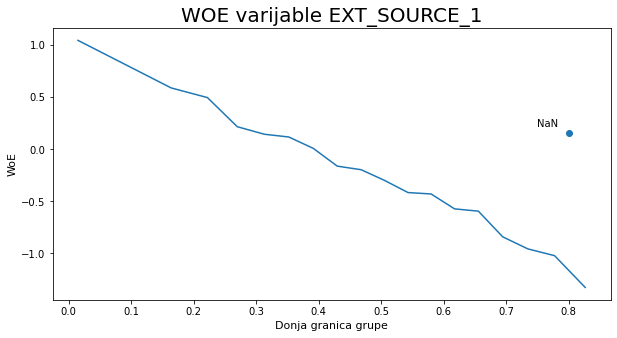

In [99]:
tmp = final_iv[final_iv['VAR_NAME']=='EXT_SOURCE_1'][['MIN_VALUE','WOE']][:-1] 
#poslednja grupa je NaN pa cemo je ukloniti

tmp['WOE'] = pd.to_numeric(tmp['WOE'])
tmp['MIN_VALUE'] = pd.to_numeric(tmp['MIN_VALUE'])

tmp.set_index('MIN_VALUE', inplace=True)

fig, ax = plt.subplots( figsize=(10, 5))

plt.title('WOE varijable EXT_SOURCE_1', fontsize=20)
plt.xlabel('Donja granica grupe', fontsize=11)
plt.ylabel('WoE', fontsize=11)

ax.plot(tmp)
ax.scatter(0.8, 0.152297)

# legend = ax.legend(loc='upper right', shadow=True, fontsize='x-large')
# legend.get_frame().set_facecolor('C0') # Put a nicer background color on the legend.

ax.text(0.75, 0.22, "NaN")

plt.show()
#fig.savefig('test.jpg')

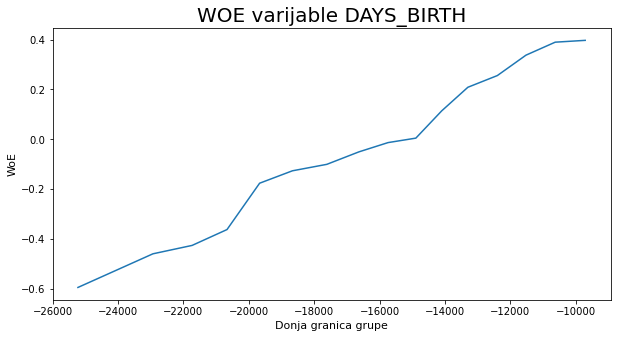

In [98]:
tmp = final_iv[final_iv['VAR_NAME']=='DAYS_BIRTH'][['MIN_VALUE','WOE']]

tmp['WOE'] = pd.to_numeric(tmp['WOE'])
tmp['MIN_VALUE'] = pd.to_numeric(tmp['MIN_VALUE'])

tmp.set_index('MIN_VALUE', inplace=True) 
fig, ax = plt.subplots( figsize=(10, 5))

plt.title('WOE varijable DAYS_BIRTH', fontsize=20)
plt.xlabel('Donja granica grupe', fontsize=11)
plt.ylabel('WoE', fontsize=11)

ax.plot(tmp)

# legend = ax.legend(loc='upper right', shadow=True, fontsize='x-large')
# legend.get_frame().set_facecolor('C0') # Put a nicer background color on the legend.


plt.show()

In [ ]:
import time

#transformisemo pocetni uzorak tako sto umesto pocetne vrednosti varijable, stavljamo njenu WOE vrednost
def WOE_transformation(data,vars):
    start = time.time()

    for var in vars:

        tmp = final_iv[final_iv['VAR_NAME']==var][['MIN_VALUE','MAX_VALUE','WOE']]

        for idx, row in data.iterrows():

            for l,r,w in zip(tmp['MIN_VALUE'],tmp['MAX_VALUE'], tmp['WOE']):

                if (pd.isna(row[var]) or (row[var]>=l and row[var]<=r)):

                    data.loc[idx, var] = w

    end = time.time()
    print(round((end-start)/60,2))

In [ ]:
vars=['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3','bureau_DAYS_CREDIT_mean','client_installments_AMT_PAYMENT_min_sum']
WOE_transformation(X_train,vars)
#WOE_transformation(X_train,['EXT_SOURCE_3'])
WOE_transformation(X_test,vars)

In [ ]:
#WOE transformacija traje dugo pa cemo rezultate sacuvati u excelu
X_test_short_list=X_test[['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3','bureau_DAYS_CREDIT_mean','client_installments_AMT_PAYMENT_min_sum']]
X_train_short_list=X_train[['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3','bureau_DAYS_CREDIT_mean','client_installments_AMT_PAYMENT_min_sum']]

In [ ]:
X_train_short_list.to_csv('X_train_short_list.csv',index = False, chunksize = 500)

In [ ]:
X_test_short_list.to_csv('X_test_short_list.csv',index = False, chunksize = 500)

In [11]:
X_train_short_list=pd.read_csv('C:\\Users\\Vlada\\Desktop\\Milica master\\X_train_short_list.csv')
X_test_short_list=pd.read_csv('C:\\Users\\Vlada\\Desktop\\Milica master\\X_test_short_list.csv')

In [15]:
grid_model = LogisticRegression()
params = {'C': [10**i for i in range(-5, 5)]}
grid = model_selection.GridSearchCV(grid_model, param_grid=params, scoring='roc_auc', cv=5, return_train_score=True)

In [16]:
grid.fit(X_train_short_list, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100,
                               1000, 10000]},
             return_train_score=True, scoring='roc_auc')

In [17]:
grid.best_params_

{'C': 100}

In [18]:
log_reg = LogisticRegression(class_weight = 'balanced',C = 100)
# Train on the training data
log_reg.fit(X_train_short_list, y_train)

LogisticRegression(C=100, class_weight='balanced')

In [19]:
log_reg_pred = log_reg.predict_proba(X_test_short_list)
log_reg_pred

array([[0.50629829, 0.49370171],
       [0.65682623, 0.34317377],
       [0.35421682, 0.64578318],
       ...,
       [0.42189706, 0.57810294],
       [0.43378152, 0.56621848],
       [0.44190262, 0.55809738]])

In [20]:
print("Accuracy on training set: {:.3f}".format(log_reg.score(X_train_short_list, y_train)))
print("Accuracy on test set: {:.3f}".format(log_reg.score(X_test_short_list, y_test)))

Accuracy on training set: 0.673
Accuracy on test set: 0.674


In [21]:
predicted = log_reg.predict(X_test_short_list)
report = classification_report(y_test, predicted)
print(report)

              precision    recall  f1-score   support

           0       0.96      0.67      0.79     56538
           1       0.15      0.67      0.25      4965

    accuracy                           0.67     61503
   macro avg       0.56      0.67      0.52     61503
weighted avg       0.89      0.67      0.75     61503



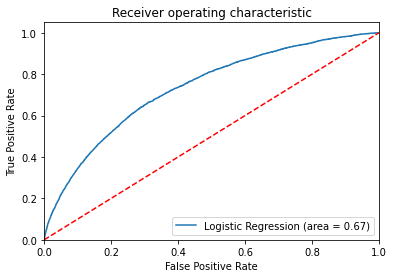

In [22]:
logit_roc_auc = roc_auc_score(y_test, log_reg.predict(X_test_short_list))
fpr, tpr, thresholds = roc_curve(y_test, log_reg.predict_proba(X_test_short_list)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()